In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import random
import glob

import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import plot_model

/home/ank/anaconda3/envs/tftry2/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def build_model():
    '''
    Build CNN model for light color classification
    '''
    num_classes = 3
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same',
                     input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.summary()
    
    return model

In [3]:
def train_model(data, model, hyper_params, model_names):   
    '''
    Train the CNN model
    data: list of training and validation data
    model: CNN model
    hyper_params: list of hyper_params
    model_names: list of model names
    '''
    
    #Unpack the data
    x_train, y_train, x_valid, y_valid = data[0],data[1],data[2],data[3],
    
    # Unpack the hyper-parameters
    lr = hyper_params[0]
    epochs = hyper_params[1]
    batch_size = hyper_params[2]

    # Upack the model names
    model_best_name = model_names[0]
    model_final_name = model_names[1]

    
 
    # Select the optimizer and set the learning rate
    opt=keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, \
                              epsilon=1e-08, decay=0.0)
    # Set the loss function
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
    # Set the check point
    checkpoint = ModelCheckpoint(filepath = model_best_name, verbose=0, save_best_only=True)
    
    # Create tensorboard  
    tensorboard =TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, \
                             write_images =True)
    start_time = time.time()
    # Fit the model and record the loss
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_valid, y_valid),
              shuffle=True,
              verbose =1,
              callbacks =[checkpoint, tensorboard]).history
    end_time = time.time()
    # Save the model at the end of training
    model.save(model_final_name)
    print('')
    print('Training time (seconds): ', end_time - start_time)
    print('Final trained model saved at %s ' % model_final_name)
    return history, model

In [4]:
def evaluate(data_test, model, hyper_params, visual=True):
    #light_colors = ["red", "green", "yellow"]
    x_test =data_test[0]
    y_test = data_test[1]
    batch_size = hyper_params[2]
    evaluation = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=0)
    print('Model Accuracy = %.2f' % (evaluation[1]))
    
    if visual:
       predict = model.predict(x_test, batch_size = batch_size)
    
       fig, axs = plt.subplots(3,3, figsize=(11, 8), facecolor='w', edgecolor='k')
       fig.subplots_adjust(hspace = .5, wspace=.001)
       axs = axs.ravel()

       for i in range(9):
          axs[i].imshow(cv2.cvtColor(x_test[i], cv2.COLOR_BGR2RGB))
          axs[i].set_title('Label: '+ str(np.argmax(y_test[i])) + \
            ', Predict: '+str(np.argmax(predict[i])))

No. of training samples: 1228, No. of test samples: 128, No. of validation samples: 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        1168      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        4640      
______________________________________________________

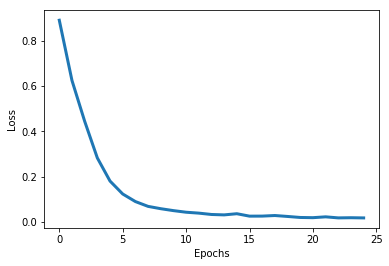

Model Accuracy = 0.99


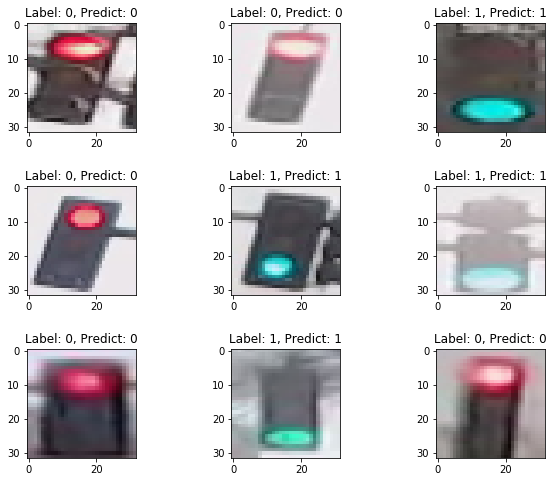

In [5]:
# The paths to the image dataset and trained models
base_image_path = 'training_images/'
light_colors = ["red", "green", "yellow"]
saved_model_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saved_model_dir):
       os.makedirs(saved_model_dir)
    
# Resize the images to the size of 32X32 and save the in the list named data
data=[]
color_counts = np.zeros(3)
for color in light_colors:
    for img_file in glob.glob(os.path.join(base_image_path, color, "*")):
        img = cv2.imread(img_file)
        if not img is None:
            img = cv2.resize(img, (32, 32))
            label = light_colors.index(color)
            assert(img.shape == (32, 32, 3))
            data.append((img, label, img_file))
            color_counts[light_colors.index(color)]+=1
                             
#Divide the data into training, validation, and test sets.                         
random.shuffle(data)
X, y, files = [], [],[]
for sample in data:
    X.append(sample[0])
    y.append(sample[1])
    files.append(sample[2])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.086,
    random_state = 832289)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.094,
    random_state = 832289)
print("No. of training samples: %d, No. of test samples: %d, No. of validation samples: %d"\
    %(len(X_train), len(X_test), len(X_valid)) )    
    
# Data preprocessing: converting to numpy array, normalizing data, and creating
# one-hot labels.
X_train=np.array(X_train)
X_valid=np.array(X_valid)
X_test=np.array(X_test)
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
encoder = LabelBinarizer()
encoder.fit(y_train)
X_train /= 255
X_valid /= 255
X_test /= 255
y_train_onehot = encoder.transform(y_train)
y_valid_onehot = encoder.transform(y_valid)
y_test_onehot = encoder.transform(y_test)
data_train=[X_train, y_train_onehot, X_valid, y_valid_onehot]
data_test=[X_test,y_test_onehot]

batch_size = 32 # batch size
lr = -4  # learning rate
epochs = 25  # number of training epochs
hyper_params = [pow(10,lr), epochs, batch_size]
   
model_best_name='model_b_lr-'+str(abs(lr))+'_ep'+str(epochs)+'_ba'+str(batch_size)\
                  +'.h'
model_best_name = os.path.join(saved_model_dir, model_best_name)             
model_final_name='model_f_lr-'+str(abs(lr))+'_ep'+str(epochs)+'_ba'+str(batch_size)\
                  +'.h'
model_final_name = os.path.join(saved_model_dir, model_final_name)               
model_names = [model_best_name, model_final_name]
    
# Build model
model = build_model()
    
plot_model(model, to_file='model.png')
   
# Training
history, model = train_model(data_train, model, hyper_params, model_names)
model_json = model.to_json()
with open("saved_models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('saved_models/model1.h5')

# Plot the loss
plt.plot(history['loss'],linewidth=3.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# Evaluate the trained model
evaluate(data_test, model, hyper_params)

In [8]:
img_test = cv2.imread("/home/ank/tl_ws/training_images/yellow1.jpg")
label = 2
img_test = cv2.resize(img_test, (32, 32))
img_test = np.array('float32')